#ColorDex Model using AutoEncoder and Decoder

In [ ]:
!pip install -q keras

In [1]:
#Importing all the libraries

from keras.layers import Conv2D, UpSampling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf

In [2]:
path = '/content/drive/MyDrive/Colab Notebooks/Color_Images'

In [3]:
#Normalize images = divide by 255
train_datagen = ImageDataGenerator(rescale=1. /255)
print(train_datagen)

In [4]:
#Resize images, if needed
train = train_datagen.flow_from_directory(path,
                                          target_size=(256, 256),
                                          batch_size = 5, 
                                          class_mode = None,
                                          shuffle = False)

# train = train_datagen.flow_from_directory(image_path,
#                                           target_size=(256, 256),
#                                           batch_size = 340,
#                                           class_mode = None)

Found 174 images belonging to 1 classes.


Convert from RGB to Lab by iterating on each image, we convert the RGB to Lab
Think of Lab image as grey image in L channel and all color info stored in A and B channels.
The input to the network will be the L channel, so we assign L channel to X vector and assign A and B to Y.

In [5]:
X = []
Y = []
for img in train[0]:
  try:
    lab = rgb2lab(img)
    X.append(lab[:,:,0])
    Y.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128
    #so we divide the values by 128 to restrict values to between -1 and 1
  except:
    print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) #dimensions to be the same for X and Y
print(X.shape)
print(Y.shape)

(5, 256, 256, 1)
(5, 256, 256, 2)


In [6]:
#Encoder

model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))

In [7]:
#Decoder
#Note: For the last layer we use tanh instead of Relu. 
#This is because we are colorizing the image in this layer using 2 filters, A and B.
#A and B values range between -1 and 1 so tanh (or hyperbolic tangent) is used
#as it also has the range between -1 and 1. 
#Other functions go from 0 to 1.
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 512)       1180160   
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 512)       2

In [9]:
history = model.fit(X, Y, validation_split=0.1, epochs = 2000, batch_size = 5)

Epoch 1/2000
1/1 [==============================] - 0s 153ms/step - loss: 0.0061 - accuracy: 0.7211 - val_loss: 0.0109 - val_accuracy: 0.5791
Epoch 2/2000
1/1 [==============================] - 0s 115ms/step - loss: 0.0063 - accuracy: 0.7224 - val_loss: 0.0096 - val_accuracy: 0.4937
Epoch 3/2000
1/1 [==============================] - 0s 104ms/step - loss: 0.0064 - accuracy: 0.6595 - val_loss: 0.0101 - val_accuracy: 0.5185
Epoch 4/2000
1/1 [==============================] - 0s 96ms/step - loss: 0.0060 - accuracy: 0.6828 - val_loss: 0.0125 - val_accuracy: 0.5908
Epoch 5/2000
1/1 [==============================] - 0s 86ms/step - loss: 0.0064 - accuracy: 0.7119 - val_loss: 0.0095 - val_accuracy: 0.4899
Epoch 6/2000
1/1 [==============================] - 0s 79ms/step - loss: 0.0061 - accuracy: 0.6688 - val_loss: 0.0094 - val_accuracy: 0.4752
Epoch 7/2000
1/1 [==============================] - 0s 79ms/step - loss: 0.0064 - accuracy: 0.6538 - val_loss: 0.0093 - val_accuracy: 0.4917
Epoch 8/20

In [12]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


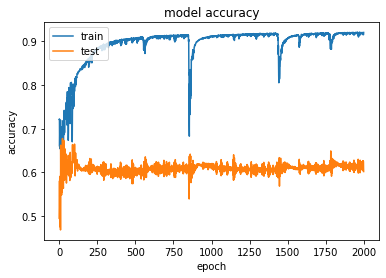

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

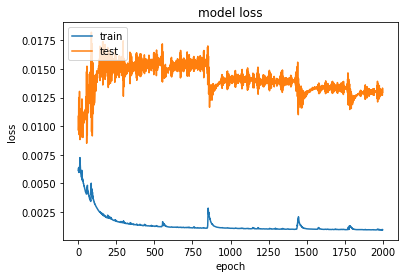

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
model.save('/content/drive/MyDrive/Colab Notebooks/colorize_autoencoder.model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/colorize_autoencoder.model/assets
